In [19]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction

In [20]:
path = 'essays/'

In [21]:
titles = os.listdir(path)

texts = []
for title in titles:
    with open(path + title, "r", encoding="ISO-8859-1") as file:
        texts.append(file.read())

In [22]:
print(titles[:10])

['essay_1.txt', 'essay_10.txt', 'essay_100.txt', 'essay_1000.txt', 'essay_1001.txt', 'essay_1002.txt', 'essay_1003.txt', 'essay_1004.txt', 'essay_1005.txt', 'essay_1006.txt']


In [23]:
# load nltk's English stopwords as variable called 'stopwords'
stopwords = nltk.corpus.stopwords.words('english')

In [24]:
print(stopwords[:10])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [25]:
# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [26]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [27]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in texts:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [30]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(texts)

CPU times: user 1min 32s, sys: 699 ms, total: 1min 32s
Wall time: 1min 33s


In [39]:
terms = tfidf_vectorizer.get_feature_names()

In [43]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

In [67]:
from sklearn.cluster import KMeans

num_clusters = 12

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

CPU times: user 59.3 s, sys: 78.5 ms, total: 59.4 s
Wall time: 59.4 s


In [68]:
from sklearn.externals import joblib

#uncomment the below to save your model 
#since I've already run my model I am loading from the pickle

#joblib.dump(km,'doc_cluster.pkl')

km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()

In [69]:
essays = { 'title': titles, 'essays': texts, 'cluster': clusters}
frame = pd.DataFrame(essays, index = [clusters] , columns = ['title', 'cluster'])

In [70]:
frame['cluster'].value_counts() #number of essays per cluster (clusters from 0 to 12)

1     272
2     204
3     187
10    155
0     136
9     125
7     109
11     99
4      93
8      85
5      57
6      51
Name: cluster, dtype: int64

In [118]:
from __future__ import print_function

print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :10]: #replace 6 with n words per cluster
        print(' %s' % vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print() #add whitespace
    print() #add whitespace
    
    print("Cluster %d titles:" % i, end='')
    for title in frame.loc[i]['title'].values.tolist():
        print(' %s,' % title, end='')
    print() #add whitespace
    print() #add whitespace
    
print()
print()


Top terms per cluster:

Cluster 0 words: b'courts', b'state', b'laws', b'justice', b'criminals', b'case', b'right', b"'s", b'crime', b'convicted',

Cluster 0 titles: essay_1005.txt, essay_1014.txt, essay_1016.txt, essay_1035.txt, essay_1038.txt, essay_1041.txt, essay_1047.txt, essay_1061.txt, essay_1086.txt, essay_1102.txt, essay_1111.txt, essay_1119.txt, essay_1121.txt, essay_1133.txt, essay_1154.txt, essay_1160.txt, essay_1164.txt, essay_1180.txt, essay_1194.txt, essay_1203.txt, essay_1206.txt, essay_1214.txt, essay_1228.txt, essay_1229.txt, essay_1246.txt, essay_1251.txt, essay_1253.txt, essay_1255.txt, essay_13.txt, essay_1302.txt, essay_131.txt, essay_1334.txt, essay_1353.txt, essay_1354.txt, essay_1356.txt, essay_1358.txt, essay_1359.txt, essay_1370.txt, essay_1379.txt, essay_1381.txt, essay_1399.txt, essay_1463.txt, essay_1469.txt, essay_1506.txt, essay_17.txt, essay_212.txt, essay_218.txt, essay_225.txt, essay_233.txt, essay_236.txt, essay_267.txt, essay_271.txt, essay_277.txt,

Cluster 3 words: b'society', b'people', b"'s", b'incarceration', b'human', b'become', b'world', b'person', b'social', b'individuals',

Cluster 3 titles: essay_101.txt, essay_103.txt, essay_1033.txt, essay_1036.txt, essay_1042.txt, essay_1065.txt, essay_1066.txt, essay_1068.txt, essay_1070.txt, essay_1076.txt, essay_1097.txt, essay_1110.txt, essay_1118.txt, essay_1141.txt, essay_1147.txt, essay_1149.txt, essay_1158.txt, essay_1165.txt, essay_1175.txt, essay_1186.txt, essay_1191.txt, essay_1216.txt, essay_1231.txt, essay_1232.txt, essay_1237.txt, essay_1238.txt, essay_1239.txt, essay_1263.txt, essay_1268.txt, essay_1269.txt, essay_1280.txt, essay_1294.txt, essay_1296.txt, essay_1308.txt, essay_1322.txt, essay_1336.txt, essay_1348.txt, essay_1349.txt, essay_1357.txt, essay_1362.txt, essay_137.txt, essay_1376.txt, essay_1393.txt, essay_140.txt, essay_1404.txt, essay_1413.txt, essay_1416.txt, essay_1417.txt, essay_1430.txt, essay_1446.txt, essay_147.txt, essay_1475.txt, essay_1476.txt, essa

Cluster 8 words: b'parole', b'offenders', b'sentence', b'year', b"'s", b'release', b'crime', b'state', b'laws', b'serve',

Cluster 8 titles: essay_1002.txt, essay_1007.txt, essay_1011.txt, essay_1013.txt, essay_1017.txt, essay_1021.txt, essay_1037.txt, essay_1058.txt, essay_1098.txt, essay_1122.txt, essay_1124.txt, essay_1135.txt, essay_1181.txt, essay_12.txt, essay_1254.txt, essay_1256.txt, essay_1257.txt, essay_1258.txt, essay_1266.txt, essay_1274.txt, essay_1287.txt, essay_1314.txt, essay_1317.txt, essay_1319.txt, essay_1324.txt, essay_1347.txt, essay_135.txt, essay_1360.txt, essay_1369.txt, essay_138.txt, essay_1383.txt, essay_1396.txt, essay_14.txt, essay_1428.txt, essay_1434.txt, essay_1447.txt, essay_1468.txt, essay_1548.txt, essay_1554.txt, essay_210.txt, essay_25.txt, essay_26.txt, essay_27.txt, essay_28.txt, essay_299.txt, essay_304.txt, essay_311.txt, essay_313.txt, essay_365.txt, essay_370.txt, essay_412.txt, essay_473.txt, essay_478.txt, essay_504.txt, essay_506.txt, essay

In [72]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]
print()
print()

In [73]:
import random

#set up colors per clusters using a dict
cluster_colors = {}
for i in range(12):
    r = lambda: random.randint(0,255)
    cluster_colors[i] = '#%02X%02X%02X' % (r(),r(),r())

#set up cluster names using a dict
cluster_names = {0: 'socioeconomic, parent, damage, abuse, gang, alcohol, drug', 
                 1: 'family, abandonment, relations, visiting, partner, mother, father, sibling', 
                 2: 'physical, condition, security, search, censorship, food, cold, hygiene, heat, misfunction, infestation, solitary', 
                 3: 'violence, fear, staff, sexual, crime, outcasts, racial, cellmate, gay, LGBTQ, dehumanize, uniform',
                 4: 'abuse, sexual, torture, humiliation, racist, assault, antagonism, exacerbation, right, violation, food, hygiene, environment, legal',
                 5: 'survival, art, reading, writing, peace, faith, prayer, meditation, practice, community, activities, hobbies, cooking, remorse, motivation, education, discipline, coping, adjustment',
                 6: 'judicial, incompetence, corruption, witness, evidence, excessive, political, jailhouse, lawyer',
                 7: 'activism, resistence, critique, race, class, change, policies, practices',
                 8: 'labor, slave, condition, safety, health',
                 9: 'rehabilitation, re-entry, education, indifference',
                 10: 'health, care, negligence, hostility, incompetence, indifference, death, injury, treatment, medication',
                 11: 'public, mispercetion, identity, stigma'}
                 
                 

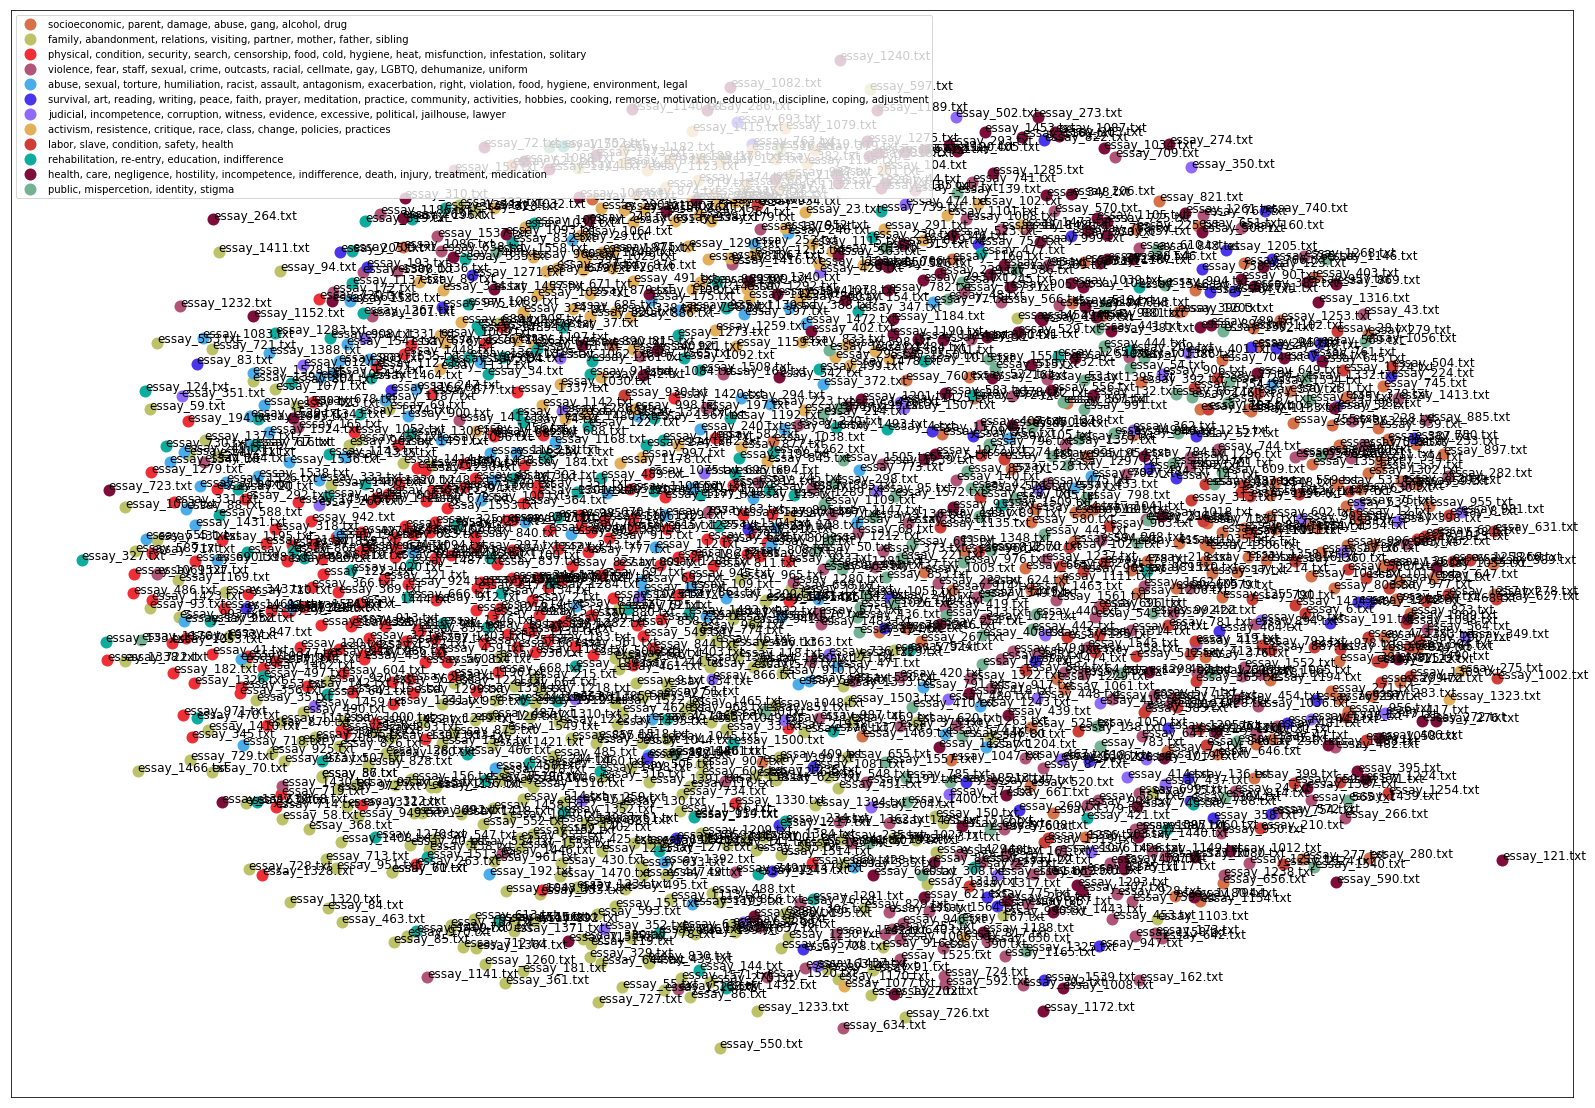

In [77]:
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(28, 20)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='False',      # ticks along the bottom edge are off
        top='False',         # ticks along the top edge are off
        labelbottom='False')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='False',      # ticks along the bottom edge are off
        top='False',         # ticks along the top edge are off
        labelleft='False')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.loc[i]['x'], df.loc[i]['y'], df.loc[i]['title'], size=12)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

In [78]:
plt.close()

In [108]:
import mpld3

#define custom toolbar location
class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 150);
      this.fig.toolbar.toolbar.attr("y", 400);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}

In [117]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')

#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }

svg.mpld3-figure {
margin-left: -100px;}
"""

# Plot 
fig, ax = plt.subplots(figsize=(15,8)) #set plot size
ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=18, 
                     label=cluster_names[name], mec='none', 
                     color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.title]
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=10, hoffset=10, css=css)
    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    
#ax.legend(numpoints=1) #show legend with only one dot

mpld3.display() #show the plot

#uncomment the below to export to html
#html = mpld3.fig_to_html(fig)
#print(html)